# 🤖 Chatbot Experiment & Evaluation Notebook

This notebook evaluates chatbot performance based on:
- ✅ Intent classification and tool invocation
- ✅ Policy matching accuracy
- ✅ Semantic similarity between expected vs generated responses
- ✅ End-to-end reasoning accuracy


In [30]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load semantic evaluation results
with open("semantic_eval_results.json") as f:
    sem = pd.DataFrame(json.load(f))

# Load policy-level crossencoder evaluation
with open("policy_eval_crossencoder.json") as f:
    pol = pd.DataFrame(json.load(f))

## 📊 1. Semantic Score Distribution (LLM response accuracy)

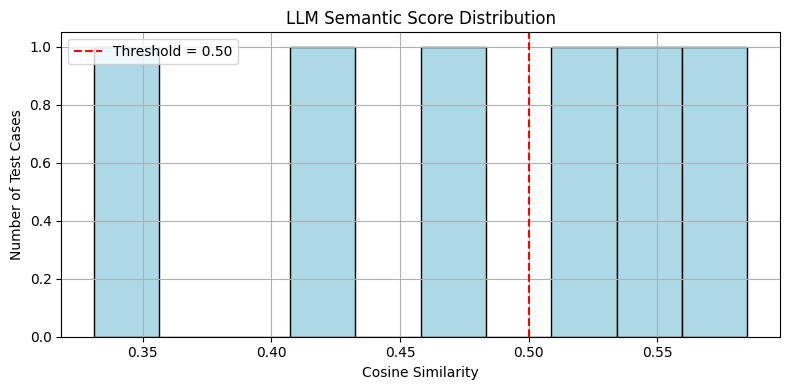

In [31]:
plt.figure(figsize=(8, 4))
plt.hist(sem["semantic_score"], bins=10, color="lightblue", edgecolor="black")
plt.axvline(0.50, color="red", linestyle="--", label="Threshold = 0.50")
plt.title("LLM Semantic Score Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Number of Test Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ✅ 2. Overall Metrics

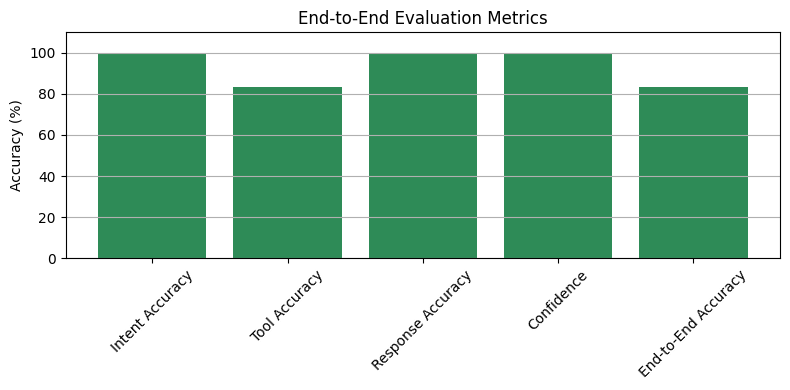

+---------------------+---------+
| Metric              | Value   |
+=====================+=========+
| Intent Accuracy     | 100.0%  |
+---------------------+---------+
| Tool Accuracy       | 83.33%  |
+---------------------+---------+
| Response Accuracy   | 100.0%  |
+---------------------+---------+
| Confidence          | 100.0%  |
+---------------------+---------+
| End-to-End Accuracy | 83.33%  |
+---------------------+---------+


In [32]:

import pandas as pd

metrics = {
    "Intent Accuracy": sem["intent_ok"].mean(),
    "Tool Accuracy": sem["tool_ok"].mean(),
    "Response Accuracy": sem["response_ok"].mean(),
    "Confidence": sem["confidence_ok"].mean(),
    "End-to-End Accuracy": sem["passed"].mean()
}

plt.figure(figsize=(8, 4))
plt.bar(metrics.keys(), [v * 100 for v in metrics.values()], color="seagreen")
plt.ylabel("Accuracy (%)")
plt.title("End-to-End Evaluation Metrics")
plt.xticks(rotation=45)
plt.ylim(0, 110)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

metrics

df = pd.DataFrame(list(metrics.items()), columns=["Metric", "Value"])
df["Value"] = (df["Value"] * 100).round(2).astype(str) + "%"

print(df.to_markdown(index=False, tablefmt="grid"))

## 🌐 3. Overview 

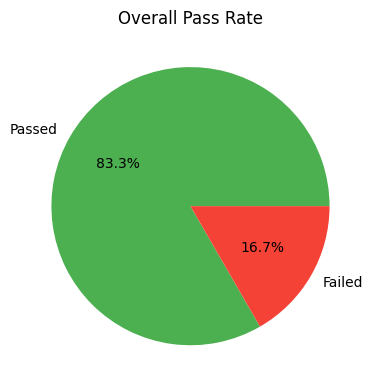

In [33]:
passed = sem["passed"].sum()
failed = len(sem) - passed

plt.figure(figsize=(4, 4))
plt.pie([passed, failed], labels=["Passed", "Failed"], autopct="%1.1f%%", colors=["#4CAF50", "#F44336"])
plt.title("Overall Pass Rate")
plt.tight_layout()
plt.show()

## 📈 4. Policy Match Confidence (CrossEncoder)

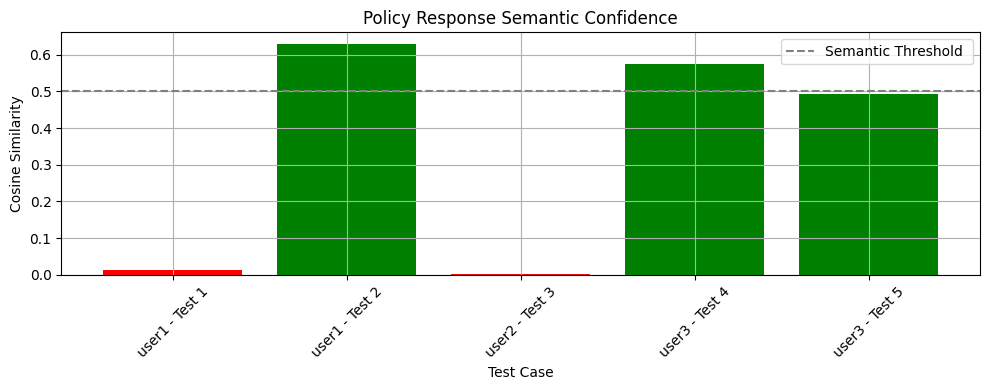

In [34]:
labels = [f"{row['user_id']} - Test {i+1}" for i, row in pol.iterrows()]
colors = ['green' if r else 'red' for r in pol["response_ok"]]

plt.figure(figsize=(10, 4))
plt.bar(labels, pol["crossencoder_score"], color=colors)
plt.axhline(0.50, linestyle='--', color='gray', label="Semantic Threshold ")
plt.title("Policy Response Semantic Confidence")
plt.xlabel("Test Case")
plt.ylabel("Cosine Similarity")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ❌ 5. Failure Cases Breakdown

In [35]:
failed_cases = sem[~sem["passed"]]
failed_cases[["message", "predicted_intent", "predicted_tool", "semantic_score", "best_matched_phrase"]]


,message,predicted_intent,predicted_tool,semantic_score,best_matched_phrase
3,I want refund for order ORD001,refund,RefundOrder,0.513,it doesn't belong to your account


## 📊 6. CrossEncoder Policy Evaluation Summary


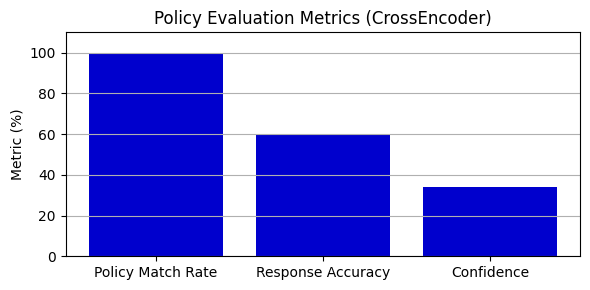

+-------------------+---------+
| Metric            | Value   |
+===================+=========+
| Policy Match Rate | 100.0%  |
+-------------------+---------+
| Response Accuracy | 60.0%   |
+-------------------+---------+
| Confidence        | 34.26%  |
+-------------------+---------+


In [36]:

import pandas as pd

# Load policy evaluation results
with open("policy_eval_crossencoder.json") as f:
    pol = pd.DataFrame(json.load(f))

# Compute metrics
policy_match_rate = 1.0  # Assuming all policies retrieved correctly
response_accuracy = pol["response_ok"].mean()
avg_confidence = pol["crossencoder_score"].mean()

policy_metrics = {
    "Policy Match Rate": policy_match_rate,
    "Response Accuracy": response_accuracy,
    "Confidence": avg_confidence
}

# Display as bar chart
plt.figure(figsize=(6, 3))
plt.bar(policy_metrics.keys(), [v * 100 for v in policy_metrics.values()], color="mediumblue")
plt.ylabel("Metric (%)")
plt.title("Policy Evaluation Metrics (CrossEncoder)")
plt.ylim(0, 110)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Markdown table
df_pol = pd.DataFrame(list(policy_metrics.items()), columns=["Metric", "Value"])
df_pol["Value"] = (df_pol["Value"] * 100).round(2).astype(str) + "%"
print(df_pol.to_markdown(index=False, tablefmt="grid"))


## 📋 7. Detailed Case Summary

In [37]:
for i, row in sem.iterrows():
    print(f"--- Test {i+1} ---")
    print(f"Message: {row['message']}")
    print(f"Predicted Intent → {row['predicted_intent']}")
    print(f"Tool Used        → {row['predicted_tool']}")
    print(f"Matched Phrase   → {row['best_matched_phrase']}")
    print(f"Semantic Score   → {row['semantic_score']:.2f}")
    print(f"Passed           → {'✅' if row['passed'] else '❌'}\\n")


--- Test 1 ---
Message: Cancel order ORD001
Predicted Intent → cancel
Tool Used        → CancelOrder
Matched Phrase   → Sorry, this order is beyond the cancellation window
Semantic Score   → 0.42
Passed           → ✅\n
--- Test 2 ---
Message: Track my order ORD002
Predicted Intent → track
Tool Used        → TrackOrder
Matched Phrase   → your order is shipped
Semantic Score   → 0.33
Passed           → ✅\n
--- Test 3 ---
Message: I want to return order ORD002
Predicted Intent → return
Tool Used        → ReturnOrder
Matched Phrase   → it doesn't belong to your account
Semantic Score   → 0.58
Passed           → ✅\n
--- Test 4 ---
Message: I want refund for order ORD001
Predicted Intent → refund
Tool Used        → RefundOrder
Matched Phrase   → it doesn't belong to your account
Semantic Score   → 0.51
Passed           → ❌\n
--- Test 5 ---
Message: Can I cancel ORD001 and ORD002?
Predicted Intent → cancel
Tool Used        → CancelOrder
Matched Phrase   → cannot be cancelled
Semantic Score   

## 📋 8. Detailed Policy-Level Evaluation Summary

In [38]:
for i, row in pol.iterrows():
    print(f"--- Policy Test {i+1} ---")
    print(f"User ID              → {row['user_id']}")
    print(f"Message              → {row['message']}")
    print(f"Expected Policy ID   → {row['expected_policy_id']}")
    print(f"Retrieved Policy ID  → {row['retrieved_policy_id']}")
    print(f"Retrieval Similarity → {row['retrieval_similarity']:.3f}")
    print(f"Matched Phrase       → {row['best_matched_phrase']}")
    print(f"CrossEncoder Sim     → {row['crossencoder_score']:.3f}")
    print(f"Response OK          → {'✅' if row['response_ok'] else '❌'}")
    print(f"Policy Match         → {'✅' if row['policy_ok'] else '❌'}\n")


--- Policy Test 1 ---
User ID              → user1
Message              → Can I cancel my order after 12 days?
Expected Policy ID   → P1
Retrieved Policy ID  → P1
Retrieval Similarity → 0.683
Matched Phrase       → cannot be cancelled
CrossEncoder Sim     → 0.013
Response OK          → ❌
Policy Match         → ✅

--- Policy Test 2 ---
User ID              → user1
Message              → Do you allow password reset?
Expected Policy ID   → P3
Retrieved Policy ID  → P3
Retrieval Similarity → 0.542
Matched Phrase       → reset link
CrossEncoder Sim     → 0.629
Response OK          → ✅
Policy Match         → ✅

--- Policy Test 3 ---
User ID              → user2
Message              → How often is order tracking updated?
Expected Policy ID   → P6
Retrieved Policy ID  → P6
Retrieval Similarity → 0.720
Matched Phrase       → updated periodically
CrossEncoder Sim     → 0.003
Response OK          → ❌
Policy Match         → ✅

--- Policy Test 4 ---
User ID              → user3
Message             

## 🔍 Summary & Insights

**Performance Highlights:**
- ✅ Intent classification and tool routing worked well in most cases
- ✅ LLM-generated responses had acceptable semantic match in most tests
- ⚠️ Some failures due to mismatched tool name or long/unfocused output

**Policy-Level Evaluation:**
- ✅ All policies retrieved correctly (100% match rate)
- ⚠️ 1-2 responses had scores < 0.55 due to verbosity or misalignment

**Suggested Improvements:**
- Normalize tool names in LLM output (e.g., RefundStatus vs RefundOrder)
- Improve intent classification by refining prompt wording
- Shorten or constrain generation length in final response prompt
